# Dictionary Inputs
In the previous example, the model parameters were built from a '.yaml' file. In some cases, the functional parameters are relatively complex and can be challenging to specify in the '.yaml' format. Therefore, the model can also be constructed using a dictionary, as demonstrated below.

## Import Modules

In [1]:
import numpy as np
import thevenin as thev

## Define the Parameters
In addition to the open circuit voltage (`ocv`), all circuit elements (i.e., `R0`, `R1`, `C1`, etc.) must be specified as functions. While `OCV` is only a function of the state of charge (`soc`, -), the circuit elements are function of both soc and temperature (`T_cell`, K). It is important that these are the only inputs to the functions and that the inputs are given in the correct order. 

The functions below come from fitting the equivalent circuit model to a 75 Ah graphite-NMC battery made by Kokam. Fits were performed using charge and discharge pulses from HPPC tests done at multiple temperatures. The `soc` was assumed constant during a single pulse and each resistor and capacitor element was fit as a constant for a given soc/temperature condition. Expressions below come from AI-Batt, which is an open-source software capable of semi-autonomously identifying algebraic expressions that map inputs (`soc` and `T_cell`) to outputs (`R0`, `R1`, `C1`).

In [2]:
stressors = {'q_dis': 1.}


def calc_xa(soc: float) -> float:
    return 8.5e-3 + soc*(7.8e-1 - 8.5e-3)


def calc_Ua(soc: float) -> float:
    xa = calc_xa(soc)
    Ua = 0.6379 + 0.5416*np.exp(-305.5309*xa) \
                + 0.0440*np.tanh(-1.*(xa-0.1958) / 0.1088) \
                - 0.1978*np.tanh((xa-1.0571) / 0.0854) \
                - 0.6875*np.tanh((xa+0.0117) / 0.0529) \
                - 0.0175*np.tanh((xa-0.5692) / 0.0875)

    return Ua


def normalize_inputs(soc: float, T_cell: float) -> dict:
    inputs = {
        'T_norm': T_cell / (273.15 + 35.),
        'Ua_norm': calc_Ua(soc) / 0.123,
    }
    return inputs


def ocv_func(soc: float) -> float:
    coeffs = np.array([
        1846.82880284425, -9142.89133579961, 19274.3547435787, -22550.631463739,
        15988.8818738468, -7038.74760241881, 1895.2432152617, -296.104300038221,
        24.6343726509044, 2.63809042502323,
    ])
    return np.polyval(coeffs, soc)


def R0_func(soc: float, T_cell: float) -> float:
    inputs = normalize_inputs(soc, T_cell)
    T_norm = inputs['T_norm']
    Ua_norm = inputs['Ua_norm']

    b = np.array([4.07e12, 23.2, -16., -47.5, 2.62])

    R0 = b[0] * np.exp( b[1] / T_norm**4 * Ua_norm**(1/4) ) \
              * np.exp( b[2] / T_norm**4 * Ua_norm**(1/3) ) \
              * np.exp( b[3] / T_norm**0.5 ) \
              * np.exp( b[4] / stressors['q_dis'] )

    return R0


def R1_func(soc: float, T_cell: float) -> float:
    inputs = normalize_inputs(soc, T_cell)
    T_norm = inputs['T_norm']
    Ua_norm = inputs['Ua_norm']

    b = np.array([2.84e-5, -12.5, 11.6, 1.96, -1.67])

    R1 = b[0] * np.exp( b[1] / T_norm**3 * Ua_norm**(1/4) ) \
              * np.exp( b[2] / T_norm**4 * Ua_norm**(1/4) ) \
              * np.exp( b[3] / stressors['q_dis'] ) \
              * np.exp( b[4] * soc**4 )

    return R1


def C1_func(soc: float, T_cell: float) -> float:
    inputs = normalize_inputs(soc, T_cell)
    T_norm = inputs['T_norm']
    Ua_norm = inputs['Ua_norm']

    b = np.array([19., -3.11, -27., 36.2, -0.256])

    C1 = b[0] * np.exp( b[1] * soc**4 ) \
              * np.exp( b[2] / T_norm**4 * Ua_norm**(1/2) ) \
              * np.exp( b[3] / T_norm**3 * Ua_norm**(1/3) ) \
              * np.exp( b[4] / stressors['q_dis']**3 )

    return C1

## Construct a Model
The model is constructed below using all necessary keyword arguments. You can see a list of these parameters using ``help(thev.Model)``.

In [3]:
params = {
    'num_RC_pairs': 1,
    'soc0': 1.,
    'capacity': 75.,
    'gamma': 0.,
    'ce': 1.,
    'mass': 1.9,
    'isothermal': False,
    'Cp': 745.,
    'T_inf': 300.,
    'h_therm': 12.,
    'A_therm': 1.,
    'ocv': ocv_func,
    'M_hyst': lambda soc: 0., 
    'R0': R0_func,
    'R1': R1_func,
    'C1': C1_func,
}

model = thev.Model(params)

## Build an Experiment
Experiments are built using the `Experiment` class. An experiment starts out empty and is then constructed by adding a series of current-, voltage-, or power-controlled steps. Each step requires knowing the control mode/units, the control value, a relative time span, and limiting criteria (optional). Control values can be specified as either constants or dynamic profiles with sinatures like `f(t: float) -> float` where `t` is the relative time of the new step, in seconds. The experiment below discharges at a nominal C/5 rate for up to 5 hours. A limit is set such that if the voltage hits 3 V then the next step is triggered early. Afterward, the battery rests for 10 min before charging at C/5 for 5 hours or until 4.2 V is reached. The final step is a 1 hour voltage hold at 4.2 V.

Note that the time span for each step is constructed as `(t_max: float, dt: float)` which is used to determine the time array as `tspan = np.arange(0., t_max + dt, dt)`. You can also construct a time array given `(t_max: float, Nt: int)` by using an integer instead of a float in the second position. In this case, `tspan = np.linspace(0., t_max, Nt)`. To learn more about building an experiment, including which limits are allowed and/or how to adjust solver settings on a per-step basis, see the documentation `help(thev.Experiment)`.

In [4]:
expr = thev.Experiment()
expr.add_step('current_A', 15., (5.*3600., 60.), limits=('voltage_V', 3.))
expr.add_step('current_A', 0., (600., 5.))
expr.add_step('current_A', -15., (5.*3600., 60.), limits=('voltage_V', 4.2))
expr.add_step('voltage_V', 4.2, (3600., 60.))

## Run the Experiment
Experiments are run using either the `run()` method, as shown below, or the `run_step()` method. To run the discharge first, perform an analysis, and then run a rest, etc. then you will want to use the `run_step()` method. Steps should always be run in order because the model's state is always updated at the end of each step in preparation for the next step. At the end of all steps you can manually reset the model state back to a resting condition at `soc0` using the `pre()` method.

The default behavior of `run()` handles all of this "complexity" for you. A single call to `run()` will execute all steps of an experiment in the correct order AND will call `pre()` at the end of all steps. To bypass the call to the pre-processor you can use the optional `reset_state=False` keyword argument. This is important if you need the model to run multiple experiments back-to-back and want the start of each experiment to be consistent with the end of the last experiment. In the case below, we use the default behaior and allow the state to reset since we are only running a single experiment.

Regardless of how you run your experiment, the return value will be a solution instance. Solution instances each contain a `vars` attribute which contains a dictionary of the output variables. Keys are generally self descriptive and include units where applicable. To quickly plot any two variables against one another, use the `plot` method with the two keys of interest specified for the `x` and `y` variables of the figure. Below, time (in hours) is plotted against voltage.

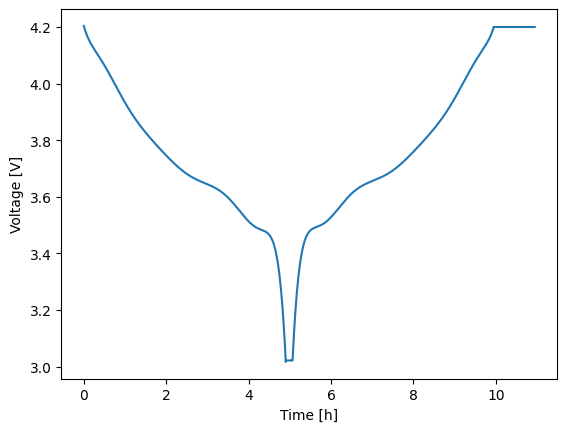

In [5]:
soln = model.run(expr)
soln.plot('time_h', 'voltage_V')